# Burn extent  validation against independent fire perimeter data
This script shows the workflow to evaluate a burn extent map against independent fire perimeter polygon data. The workflow provides a visual comparison as well as False Positive and True Positive statistics that can be used to construct Receiver Pperating Characteristic (ROC) curves.

## Import the required modules 
Import the `validationtoolbox`:

In [1]:
import xarray as xr
import numpy as np
import validationtoolbox as val
import matplotlib.pyplot as plt
%matplotlib inline

## Load  burn severity map
Load the saved NetCDF file containing the burn severity map that was produced.
The example below assumes access to the indicated location in the NCI file system.
If no burn severity map was produced yet, then first do so, for example, using the BurnCube Burn Mapping Example Notebook.

In [2]:
sev = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/TestSites/BurnMapping_SirIvan_2017.nc')

## Convert burn severity map to a burn extent map
The `burnpixel_masking` function from  the validation toolbox converts the severity data into a binary map.

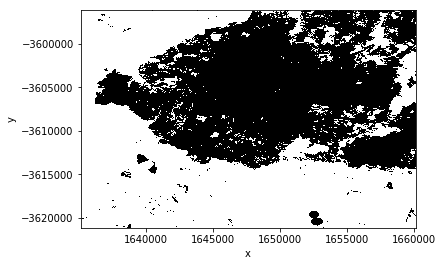

In [3]:
Burnpixel = val.burnpixel_masking(sev,'Medium') # mask the burnt area with "Medium" burnt area
Burnpixel.plot.imshow(cmap='binary',add_colorbar=False)

## Separating the burned area into forest and non-forest components
This step uses the `treecover_masking` tool to combine the burn map with binary mapping of (pre-fire) forest and non-forest land cover.
The forest cover mapping is derived from ANU's extended and resampled NCAS mapping available through www.ausenv.online.

Required inputs:

    "year" should be before the year before the fire event, 
    "data" the binary burn extent map with x,y
    "prctg" the treecover fraction threshold used for forest mapping, default is 60
Outputs:

    forest mask, with 1 for forest and 0 for non-forest
    non-forest mask, with 1 for non-forest and 0 for forest
The resulting maps show the burn forest and non-forest areas, respectively.
    

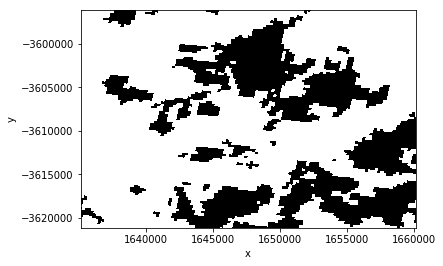

In [4]:
#reminder: forest mask has to be derived from the tree cover data before fire occured
mask=val.treecover_masking(year=2016,data=Burnpixel,prctg=60) 
mask.ForestMask.plot.imshow(cmap='binary',add_colorbar=False)

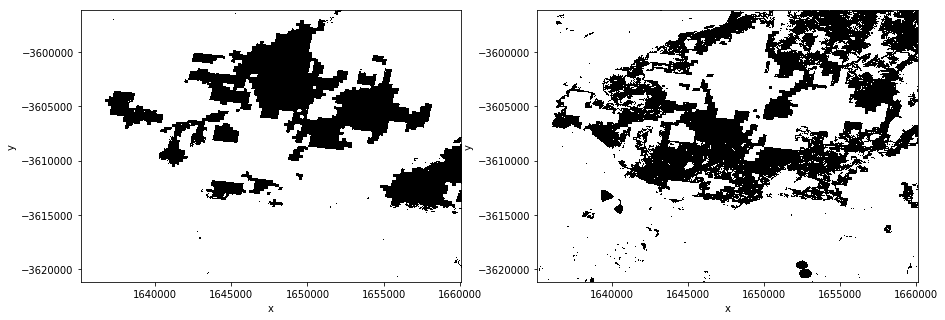

In [5]:
ForestBurned = Burnpixel*mask.ForestMask # burned pixel found in the forest area
NoneForestBurned = Burnpixel*mask.NoneForestMask # burned pixel found in the non-forest area
fig,axes=plt.subplots(ncols=2,figsize=[15,5])
ForestBurned.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False)
NoneForestBurned.plot.imshow(ax=axes[1],cmap='binary',add_colorbar=False)

## Generate validation map from fire perimeter polygon data
Use the function `CreateValidatedBurnMask` to create a validation mask from the shapefile(s) of fire perimeters polygon data.

Required inputs:

    BurnPixel: burned pixel 
    State: abbreviation of state or territory name 
    Validation_period: start and end of corresponding burn occurence period
    
The output includes a binary grid for each time step, which can be summed up if a single mask is required:


In [6]:
ValidationMask=val.CreateValidatedBurnMask(Burnpixel,State='NSW', Validation_period=("2017-01-01","2017-12-31"))
ValidationMask = ValidationMask.sum('time') #create one mask with all the burned area

I am densified (external_values, 72 elements)


## Validation map
The validation map can be produced with forest and non-forest validation results combined or produced separately:
When using `validationtoolbox.validate`, forest and non-forest land cover will not be separately considered.
When using `validationtoolbox.validate_forest_grass`, forest and non-forest will be evaluated separately and shown in the same figure.

The following example shows the validation result for burn mapping, with forest pixels in a darker shades and non-forest pixels in a lighter shade.

The false positive and truth positive rate for forest burnt area: 0.001, 0.974
The false positive and truth positive rate for non-forest burnt area: 0.014, 0.768


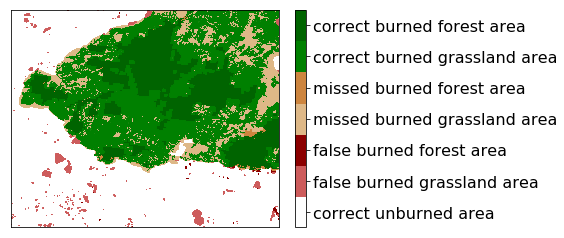

In [7]:
a,b = val.validate_forest_grass(Test_Array = Burnpixel, Validated_Array = ValidationMask,Mask = mask, plot=True)
print('The false positive and truth positive rate for forest burnt area: %.3f, %.3f' %(a[0],a[1]))
print('The false positive and truth positive rate for non-forest burnt area: %.3f, %.3f' %(b[0],b[1]))